# NUPAT AI Fellowship – Stage Two Case Study
This notebook covers:
1) Exploratory Data Analysis (EDA) & market insights
2) Rule-based fraud labeling + ML model
3) Strategic recommendation (Kenya low-volume segment)

Assumptions:
- Timestamps are treated as UTC unless stated otherwise.
- Currency conversion: divide quote-currency amounts by 1500 to convert to USD.


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TRADES_PATH = "data/trades.csv"
ACTIVITY_PATH = "data/user_activity.csv"

trades = pd.read_csv(TRADES_PATH)
activity = pd.read_csv(ACTIVITY_PATH)

# Parse timestamps (your files are ISO strings)
trades["timestamp"] = pd.to_datetime(trades["timestamp"], utc=True, errors="coerce")
activity["timestamp"] = pd.to_datetime(activity["timestamp"], utc=True, errors="coerce")

# In your trades.csv, there is no `price` column; we infer it:
# amount ≈ price * volume  =>  price = amount / volume
trades["price"] = trades["amount"] / trades["volume"]

trades.head(), activity.head()


(      pair    amount     volume  side                        timestamp  \
 0  AAVENGN    500.26   0.001222   buy 2024-12-03 01:42:07.072672+00:00   
 1   ADANGN    889.20   0.500000  sell 2024-12-02 11:29:56.860014+00:00   
 2   ADANGN  30653.12  17.100000  sell 2024-11-30 05:25:49.991660+00:00   
 3   ADANGN   1978.36   1.100000  sell 2024-12-07 07:41:02.191598+00:00   
 4   ADANGN   2913.62   1.600000  sell 2024-12-07 21:16:11.791118+00:00   
 
                     user_id          price  
 0    541-1561-1521-1561-148  409287.636938  
 1    491-1541-1521-1571-156    1778.400000  
 2  1021-1481-1521-1561-1100    1792.580117  
 3    981-1571-1521-1971-151    1798.509091  
 4    981-1571-1521-1971-151    1821.012500  ,
   asset    amount activity_type                        timestamp  \
 0   NGN  131062.0    withdrawal 2025-01-17 14:37:56.806446+00:00   
 1   NGN   50000.0    withdrawal 2025-01-17 14:37:56.818033+00:00   
 2   NGN  131062.0       deposit 2025-01-17 14:37:56.853225+00:0

Part 1.1 — Market Dynamics

Question: Top 3 most traded pairs by total USD volume, using 1500 for conversion.

In [75]:
RATE_TO_USD = 1500.0

trades["usd_notional"] = trades["amount"] / RATE_TO_USD  # amount is in quote currency

pair_usd_volume = (
    trades.groupby("pair")["usd_notional"]
    .sum()
    .sort_values(ascending=False)
)

top3_pairs = pair_usd_volume.head(3).reset_index()
top3_pairs.columns = ["pair", "total_usd_volume"]
top3_pairs


,pair,total_usd_volume
0,BTCNGN,136215.488680
1,USDTNGN,59180.573580
2,ETHNGN,9764.589513


Visualization cell

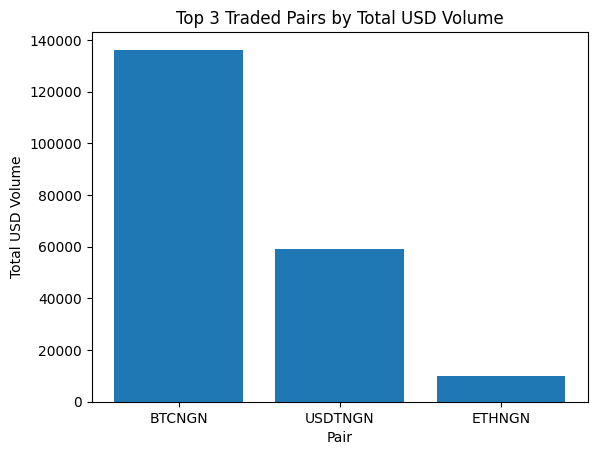

In [76]:
plt.figure()
plt.bar(top3_pairs["pair"], top3_pairs["total_usd_volume"])
plt.title("Top 3 Traded Pairs by Total USD Volume")
plt.xlabel("Pair")
plt.ylabel("Total USD Volume")
plt.show()


Part 1.2 — Volatility Analysis (BTCNGN)

Question: Calculate and plot the 7-day rolling average of daily price volatility for BTCNGN.

Definition (simple + defensible):

Compute intraday log returns of trade prices

Daily volatility = std dev of intraday log returns (per day)

Then compute 7-day rolling mean of that daily volatility

In [77]:
btc = trades[trades["pair"] == "BTCNGN"].sort_values("timestamp").copy()
btc["date"] = btc["timestamp"].dt.floor("D")

btc["log_price"] = np.log(btc["price"])
btc["log_ret"] = btc.groupby("date")["log_price"].diff()

daily_vol = btc.groupby("date")["log_ret"].std(ddof=0)  # daily intraday volatility
roll7 = daily_vol.rolling(7, min_periods=1).mean()

plt.figure()
plt.plot(roll7.index, roll7.values)
plt.title("BTCNGN: 7-Day Rolling Average of Daily Price Volatility (Log-Return Std)")
plt.xlabel("Date")
plt.ylabel("Rolling Volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

daily_vol.head(), roll7.head()


(date
 2024-11-27 00:00:00+00:00    0.003688
 2024-11-28 00:00:00+00:00    0.005215
 2024-11-29 00:00:00+00:00    0.004118
 2024-11-30 00:00:00+00:00    0.018235
 2024-12-01 00:00:00+00:00    0.019024
 Name: log_ret, dtype: float64,
 date
 2024-11-27 00:00:00+00:00    0.003688
 2024-11-28 00:00:00+00:00    0.004452
 2024-11-29 00:00:00+00:00    0.004341
 2024-11-30 00:00:00+00:00    0.007814
 2024-12-01 00:00:00+00:00    0.010056
 Name: log_ret, dtype: float64)

Part 1.3 — User Behavior (Deposit Peaks)

Question: Is there a specific day of week or hour of day when deposits are highest?

Since your user_activity.csv contains deposit/withdrawal and amount but no “deposit count” definition, the most direct interpretation is:

Highest deposits = highest number of deposit events (frequency)
(We can also do “highest total deposited amount” later if you want.)

A) Day of week peak (counts)

In [78]:
dep = activity[activity["activity_type"] == "deposit"].copy()
dep["dow"] = dep["timestamp"].dt.day_name()
dep["hour"] = dep["timestamp"].dt.hour

dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_counts = dep.groupby("dow").size().reindex(dow_order, fill_value=0)

plt.figure()
plt.bar(dow_counts.index, dow_counts.values)
plt.title("Deposit Frequency by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Deposits")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

dow_counts.sort_values(ascending=False).head(3)


dow
Friday       671
Saturday     544
Wednesday    378
dtype: int64

B) Hour of day peak (counts)

In [79]:
hour_counts = dep.groupby("hour").size().reindex(range(24), fill_value=0)

plt.figure()
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Deposit Frequency by Hour of Day (UTC)")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Deposits")
plt.tight_layout()
plt.show()

hour_counts.idxmax(), hour_counts.max()


(15, np.int64(162))

C) Heatmap (day × hour)

In [80]:
heat = (
    dep.pivot_table(index="dow", columns="hour", values="user_id", aggfunc="count")
    .reindex(dow_order)
    .fillna(0)
)

plt.figure()
plt.imshow(heat.values, aspect="auto")
plt.title("Deposit Frequency Heatmap (Day vs Hour, UTC)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(range(len(dow_order)), dow_order)
plt.xticks(range(24), range(24), rotation=0)
plt.colorbar(label="Deposit Count")
plt.tight_layout()
plt.show()

# peak cell
peak_day, peak_hour = heat.stack().idxmax()
peak_day, peak_hour, int(heat.loc[peak_day, peak_hour])


('Friday', np.int32(15), 98)

## Part 2: Fraud Detection (User-Level Model)

Fraud pattern of interest:
1) User deposits funds
2) Makes minimal trades (or very low trading volume)
3) Quickly withdraws most of the deposited amount

We will:
- Engineer user-level features from both datasets
- Create a rule-based "suspicious" label
- Train a classifier to predict it
- Evaluate with fraud-appropriate metrics (precision/recall, PR-AUC)


In [81]:
import pandas as pd
import numpy as np

# ---------- Safety checks (so notebook runs top-to-bottom) ----------
# If trades/activity were not loaded earlier, load them here.
TRADES_PATH = "data/trades.csv"
ACTIVITY_PATH = "data/user_activity.csv"

if "trades" not in globals():
    trades = pd.read_csv(TRADES_PATH)
if "activity" not in globals():
    activity = pd.read_csv(ACTIVITY_PATH)

# Parse timestamps (your files appear to contain ISO timestamps; robust to UNIX too)
def parse_timestamp(s):
    # Try datetime parsing first
    dt = pd.to_datetime(s, utc=True, errors="coerce")
    if dt.isna().all():
        # Fallback: assume UNIX seconds if parsing failed completely
        return pd.to_datetime(s, unit="s", utc=True, errors="coerce")
    return dt

trades["timestamp"] = parse_timestamp(trades["timestamp"])
activity["timestamp"] = parse_timestamp(activity["timestamp"])

# Ensure required columns exist (robust notebook behavior)
required_trades_cols = {"timestamp", "user_id", "pair", "side", "volume"}
required_activity_cols = {"timestamp", "user_id", "activity_type", "asset"}

missing_trades = required_trades_cols - set(trades.columns)
missing_activity = required_activity_cols - set(activity.columns)

if missing_trades:
    raise ValueError(f"trades.csv missing columns: {missing_trades}")
if missing_activity:
    raise ValueError(f"user_activity.csv missing columns: {missing_activity}")

# In your trades.csv, we infer price from amount/volume (amount = price * volume)
# If amount not present, we fallback to using volume only for notional-like features.
if "amount" in trades.columns:
    trades["price"] = trades["amount"] / trades["volume"]
else:
    trades["amount"] = np.nan
    trades["price"] = np.nan

# In your activity.csv, we expect an 'amount' column for deposited/withdrawn value.
# If absent, we can still do frequency-based features but amounts become NaN.
if "amount" not in activity.columns:
    activity["amount"] = np.nan

RATE_TO_USD = 1500.0  # required conversion rule in the prompt

# Trade notional in USD (quote currency amount / 1500)
trades["usd_notional"] = trades["amount"] / RATE_TO_USD

# Helper: extract base asset from pair like BTCNGN -> BTC
# We take the leading letters until the first digit (if any) or assume first 3/4 chars.
# For your dataset examples (BTCNGN, ETHKES, USDTNGN), this works well:
def extract_base(pair):
    if not isinstance(pair, str) or len(pair) < 3:
        return np.nan
    # Common bases are BTC, ETH, USDT; handle USDT explicitly
    if pair.startswith("USDT"):
        return "USDT"
    return pair[:3]  # BTC, ETH, etc.

trades["base_asset"] = trades["pair"].apply(extract_base)

# Quick view
trades.head(), activity.head()


(      pair    amount     volume  side                        timestamp  \
 0  AAVENGN    500.26   0.001222   buy 2024-12-03 01:42:07.072672+00:00   
 1   ADANGN    889.20   0.500000  sell 2024-12-02 11:29:56.860014+00:00   
 2   ADANGN  30653.12  17.100000  sell 2024-11-30 05:25:49.991660+00:00   
 3   ADANGN   1978.36   1.100000  sell 2024-12-07 07:41:02.191598+00:00   
 4   ADANGN   2913.62   1.600000  sell 2024-12-07 21:16:11.791118+00:00   
 
                     user_id          price  usd_notional base_asset  
 0    541-1561-1521-1561-148  409287.636938      0.333507        AAV  
 1    491-1541-1521-1571-156    1778.400000      0.592800        ADA  
 2  1021-1481-1521-1561-1100    1792.580117     20.435413        ADA  
 3    981-1571-1521-1971-151    1798.509091      1.318907        ADA  
 4    981-1571-1521-1971-151    1821.012500      1.942413        ADA  ,
   asset    amount activity_type                        timestamp  \
 0   NGN  131062.0    withdrawal 2025-01-17 14:37:56

2.2 Rule-based Target Labeling (define “suspicious”)

### Target Label (Rule-Based)

We define a user as **suspicious** if they closely follow the described pattern:
- They deposit funds
- They withdraw **most** of what they deposited
- They do **minimal trading**
- They withdraw **quickly** after first deposit

Rule (interpretable and adjustable):
- deposit_usd > 0
- withdraw_to_deposit_ratio >= 0.9
- trade_to_deposit_ratio <= 0.05
- hours_dep_to_wd <= 48 hours

This label is **not ground truth**; it's a heuristic proxy used to train an initial model.


In [82]:
# Rule thresholds (kept as variables for easy tuning / explanation)
MIN_WITHDRAW_RATIO = 0.90     # withdraw >= 90% of deposits
MAX_TRADE_RATIO = 0.05        # trade <= 5% of deposited amount
MAX_HOURS_TO_WITHDRAW = 48.0  # withdraw within 48 hours
MIN_DEPOSIT_USD = 1e-6        # must have a deposit


feat["suspicious_rule"] = (
    (feat["deposit_usd"] > MIN_DEPOSIT_USD) &
    (feat["withdraw_to_deposit_ratio"] >= MIN_WITHDRAW_RATIO) &
    (feat["trade_to_deposit_ratio"] <= MAX_TRADE_RATIO) &
    (feat["hours_dep_to_wd"].notna()) &
    (feat["hours_dep_to_wd"] <= MAX_HOURS_TO_WITHDRAW)
).astype(int)

# Inspect class balance
feat["suspicious_rule"].value_counts(dropna=False)


suspicious_rule
0    1194
1       5
Name: count, dtype: int64

sanity-check which users got flagged

In [83]:
feat.loc[feat["suspicious_rule"] == 1, [
    "deposit_usd","withdraw_usd","withdraw_to_deposit_ratio",
    "trade_usd_total","trade_to_deposit_ratio","hours_dep_to_wd",
    "deposit_count","withdraw_count","trade_count"
]].head(10)


,deposit_usd,withdraw_usd,withdraw_to_deposit_ratio,trade_usd_total,trade_to_deposit_ratio,hours_dep_to_wd,deposit_count,withdraw_count,trade_count
user_id,,,,,,,,,
481-11011-1521-1971-1100,6784.555333,7468.666667,1.100834,2.355807,0.000347,0.474291,64,14,2
501-1971-1521-1561-157,9823.094000,8933.333333,0.909422,13.258260,0.001350,12.635227,32,7,4
551-11021-1521-1971-199,570.708667,589.800000,1.033452,6.703823,0.011746,3.027006,131,6,1
971-1561-1521-1561-1101,4.533333,4.256000,0.938824,0.223753,0.049357,11.278688,1,1,1
991-1491-1521-1971-154,8501.940000,8182.933333,0.962478,4.273373,0.000503,0.169853,105,31,1


### Model Training

We train a model to predict the rule-based suspicious label.
Note: The goal here is not to "beat" the rule, but to:
- Learn patterns that generalize beyond hard thresholds
- Produce probability scores for triage (e.g., send top 1% for review)


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Feature set (numerical only for simplicity + robustness)
feature_cols = [
    "deposit_usd","withdraw_usd","withdraw_to_deposit_ratio",
    "trade_usd_total","trade_to_deposit_ratio",
    "deposit_count","withdraw_count","trade_count",
    "unique_pairs_traded","unique_base_assets_traded",
    "unique_deposit_assets","unique_withdraw_assets",
    "buy_count","sell_count","buy_sell_ratio",
    "hours_dep_to_wd","hours_dep_to_first_trade"
]

X = feat[feature_cols].copy()
y = feat["suspicious_rule"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y if y.nunique() > 1 else None
)

# Logistic Regression pipeline (impute -> scale -> model)
logreg = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

# Random Forest pipeline (impute -> model)
rf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample",
        min_samples_leaf=2
    ))
])

logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

"Models trained."


'Models trained.'

### 2.4 Evaluation (fraud context: precision vs recall)

### Evaluation Strategy (Fraud Context)

In fraud detection, **false negatives** (missing fraud) can be very costly, so **recall** is often prioritized.
However, extremely low precision creates too many alerts for investigators.

Practical approach:
- Optimize for **high recall at acceptable precision**
- Use **Precision-Recall AUC (Average Precision)** since classes are imbalanced
- Choose a threshold depending on operational capacity (review team bandwidth)


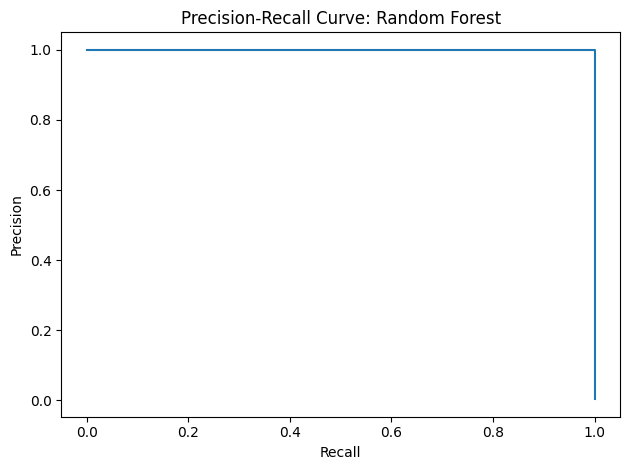

In [85]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve
)

def evaluate_model(name, model, X_test, y_test):
    # Probabilities for PR-AUC and threshold tuning
    proba = model.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)  # default threshold

    print(f"\n=== {name} ===")
    print("ROC-AUC:", roc_auc_score(y_test, proba) if y_test.nunique() > 1 else "N/A")
    print("PR-AUC (Average Precision):", average_precision_score(y_test, proba) if y_test.nunique() > 1 else "N/A")
    print("\nClassification Report (threshold=0.5):")
    print(classification_report(y_test, pred, digits=4))

    cm = confusion_matrix(y_test, pred)
    print("Confusion Matrix:\n", cm)

    # Plot Precision-Recall curve
    if y_test.nunique() > 1:
        precision, recall, thresholds = precision_recall_curve(y_test, proba)
        plt.figure()
        plt.plot(recall, precision)
        plt.title(f"Precision-Recall Curve: {name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.tight_layout()
        plt.show()

    return proba

proba_logreg = evaluate_model("Logistic Regression", logreg, X_test, y_test)
proba_rf = evaluate_model("Random Forest", rf, X_test, y_test)


### 2.5 Threshold tuning (pick a recall-focused operating point)

This is where you show maturity: you’re not stuck with 0.5 threshold.

### Threshold Selection (Operational Triage)

Instead of a fixed 0.5 threshold, we can choose a threshold that targets:
- High recall (catch most suspicious users)
- While keeping precision within review capacity

Below: we pick the threshold that achieves recall ≥ 0.90 (if possible) and reports the resulting precision.


In [86]:
from sklearn.metrics import precision_score, recall_score

def pick_threshold_for_recall(y_true, proba, target_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, proba)

    # thresholds has length = len(precision)-1
    best = None
    for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
        if r >= target_recall:
            best = (t, p, r)
            break
    return best

if y_test.nunique() > 1:
    best_lr = pick_threshold_for_recall(y_test.values, proba_logreg, target_recall=0.90)
    best_rf = pick_threshold_for_recall(y_test.values, proba_rf, target_recall=0.90)

    print("LogReg threshold for recall>=0.90:", best_lr)
    print("RF threshold for recall>=0.90:", best_rf)

    # Example: apply RF tuned threshold if it exists
    if best_rf is not None:
        t, p, r = best_rf
        tuned_pred = (proba_rf >= t).astype(int)
        print("\nRF tuned report:")
        print("Precision:", precision_score(y_test, tuned_pred))
        print("Recall:", recall_score(y_test, tuned_pred))


Precision: 0.0033333333333333335
Recall: 1.0


### 2.6 Feature importance (Random Forest)

### Feature Importance (Model Interpretability)

Random Forest feature importance helps explain what drives suspicious predictions.
This improves trust and supports actionability (what signals to monitor).


In [87]:
# Extract RF feature importances (requires accessing the trained estimator)
rf_est = rf.named_steps["model"]
importances = rf_est.feature_importances_

fi = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values("importance", ascending=False)

plt.figure()
plt.bar(fi["feature"].head(12), fi["importance"].head(12))
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

fi.head(15)


,feature,importance
0,deposit_usd,0.272091
3,trade_usd_total,0.122313
1,withdraw_usd,0.122256
5,deposit_count,0.106412
16,hours_dep_to_first_trade,0.092785
15,hours_dep_to_wd,0.064788
4,trade_to_deposit_ratio,0.059721
2,withdraw_to_deposit_ratio,0.046772
6,withdraw_count,0.039227
14,buy_sell_ratio,0.036643


# Part 3: Strategic Recommendation
## Defining a “Low-Volume Trader” Segment in Kenya

### Business Question
The product team wants to launch a **“Low-Volume Trader” marketing campaign in Kenya**.
Using the data, we define a clear, data-driven target audience.

---

## Step 1: Identify Kenyan Users

Since trading pairs include quote currencies (e.g., BTCNGN, ETHKES, USDTNGN),
we identify Kenyan users as those who have traded on **KES-denominated pairs** (e.g., ETHKES).

Definition:
- Users who have at least one trade where the pair ends with **“KES”**

This ensures we are targeting users actively participating in the Kenyan market.

---

## Step 2: Define “Low-Volume Trader”

We define “Low-Volume Traders” using objective transaction behavior.

### Key Data Points Used to Create This Segment:

### 1️ Total Trading Volume (USD Equivalent)
- Compute each user's total trading notional (converted using the fixed rate of 1500).
- Define low-volume traders as users in the **bottom 30–40%** of USD trading volume among Kenyan users.

Why this matters:
- These users are active but under-engaged.
- They represent upside growth potential through incentives or education.

---

### 2️ Trading Frequency
- Number of trades executed.
- Target users with:
  - Trade count below median
  - OR long inactivity gaps between trades

Why this matters:
- Indicates casual or experimental users.
- These users may need nudges (reduced fees, simplified UI, onboarding guides).

---

### 3️ Deposit vs Trade Utilization Ratio
- Ratio = Total Trading Volume / Total Deposits
- Low ratio (< 0.5) indicates users who deposit but barely trade.

Why this matters:
- These users trust the platform (they deposit)
- But are not fully utilizing trading features
- Strong candidates for education-driven campaigns

---

## Final Target Segment Definition

A Kenyan “Low-Volume Trader” can be defined as:

A user who:
- Has traded at least once on a KES pair
- Has total trading USD volume in the bottom 40% of Kenyan traders
- Has low trade frequency OR low trade-to-deposit utilization ratio

---

## Marketing Strategy Recommendation

Based on this segment, the campaign should focus on:

### Education + Incentives
- “Start Trading with KES – Low Fees for Firs
